In [1]:
import torch

def get_device():
    """Detects accelerator device. The possible devices are:
    1. cuda - this is preferred
    2. mps - this is for mac devices
    3. cpu - this is returned if there are no accelerator devices
    available.

    Returns:
        str: name of accelerator device available.
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [2]:
print(torch.__version__)

2.0.1+cu118


##  Create model and transforms

In [8]:
import torchvision
from torchvision import models

def get_memory():
    if get_device() == 'cuda':
        total_free_memory, total_memory = torch.cuda.mem_get_info()
        print(f'Device is cuda')
        print(f"Total free GPU memory: {round(total_free_memory * 1e-9, 3)} GB")
        print(f"Total GPU memory: {round(total_memory * 1e-9, 3)} GB")
    elif get_device() == 'mps':
        print(f'Device is mps')
        from torch import mps
        total_memory = mps.driver_allocated_memory()
        print(f"mps memory info: {round(mps.driver_allocated_memory()*1e-6, 3)} MB")
    else:
        total_memory = 0
    return total_memory

def create_effnet_model(num_classes: int = 10):
    memory = get_memory()
    if round(memory * 1e-9, 3) >= 16:
        BATCH_SIZE = 128
        IMAGE_SIZE = 224
    else:
        BATCH_SIZE = 32
        IMAGE_SIZE = 128

    model_weights = models.ResNet50_Weights.DEFAULT
    transforms = model_weights.transforms()
    transforms.crop_size = IMAGE_SIZE
    transforms.resize_size = IMAGE_SIZE
    model = models.resnet50(weights = model_weights)
    model.fc = torch.nn.Linear(in_features = 2048,
                               out_features = num_classes)
    return model, transforms, BATCH_SIZE

In [9]:
model, transforms, BATCH_SIZE = create_effnet_model()

Device is cuda
Total free GPU memory: 15.727 GB
Total GPU memory: 15.835 GB


In [5]:
total_params = sum(param.numel() for param in model.parameters())
print(f"[INFO] Total number of parameters: {total_params}")

[INFO] Total number of parameters: 23528522


PyTorch speedups will be most noticeable when as much of the GPU is being used. This means that a larger model may take longer to train on the whole but will be much faster to train than if it were to be trained without using torch 2.0.

We can increase GPU utilization by:
* Using larger models
* Increasing the batch size
* Increase the data size (use 224 x 224 dimension images)
* Increase embedding size for data
* Decreasing data transfer: transferring data across devices will slow down a GPU.

In [6]:
if get_device() == 'cuda':
    major, minor = torch.cuda.get_device_capability(get_device())
    GPU_SCORE = major + float("0." + str(minor))
    if GPU_SCORE >= 8.0:
        torch.backends.cuda.matmul.allow_tf32 = True
        print(f"[INFO] Using GPU with {GPU_SCORE} compute capability, enabling TensorFloat32")
    else:
        print(f"[INFO] Using GPU with {GPU_SCORE} compute capability, not enabling TensorFloat32")
else:
    print(f"[INFO] Not using cuda device. Skip setting Tensorfloat32")

[INFO] Using GPU with 7.5 compute capability, not enabling TensorFloat32


Getting data

In [7]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False, # want the test split
                                            download=True,
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170498071/170498071 [00:14<00:00, 12122065.46it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


Creating dataloaders

In [10]:
import os
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS)

### Write training functions

In [15]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch

    Args:
        epoch (int): epoch number
        loss_fn (torch.nn.Module): PyTorch loss function to minimize
        optimizer (torch.optim.Optimizer): PyTorch optimizer object
        device (torch.device): PyTorch device
        model (torch.nn.Module): Defaults to torch.nn.Module.
        dataloader (torch.utils.data.DataLoader): Defaults to torch.utils.data.DataLoader.
        disable_progress_bar (bool, optional): Defaults to False.

    Returns Tuple[float, float]: A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example: (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0,0
    progress_bar = tqdm(
        enumerate(dataloader),
        desc = f"Training Epoch {epoch}",
        total = len(dataloader),
        disable = disable_progress_bar
    )

    for batch, (X, y) in progress_bar:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch+1),
                "train_acc": train_acc / (batch+1)
            }
        )

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
    """Tests a PyTorch model for a given epoch

    Args:
        epoch (int): Epoch number
        model (torch.nn.Module): PyTorch model
        dataloader (torch.utils.data.DataLoader): Test dataloader
        loss_fn (torch.nn.Module): Loss function
        device (torch.device): Torch device
        disable_progress_bar (bool, optional): Defaults to False.

    Returns:
        Tuple[float, float]: Tuple of testing loss and testing accuracy metrics
    """
    model.eval()
    test_loss, test_acc = 0, 0
    progress_bar = tqdm(
        enumerate(dataloader),
        desc = f"Testing Epoch {epoch}",
        total = len(dataloader),
        disable = disable_progress_bar
    )

    with torch.no_grad():
        for batch, (X, y) in progress_bar:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

            progress_bar.set_postfix(
                {
                    "test_loss": test_loss/(batch+1),
                    "test_acc": test_acc/(batch+1)
                }
            )

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
    """Trains and tests a PyTorch model by passing it through train_step()
    and test_step() functions for every epoch. Stores evaluation metrics.

    Args:
        model (torch.nn.Module): PyTorch model
        train_dataloader (torch.utils.data.DataLoader): train dataloader
        test_dataloader (torch.utils.data.DataLoader): test dataloader
        optimizer (torch.optim.Optimizer): PyTorch optimizer
        loss_fn (torch.nn.Module): PyTorch loss function
        epochs (int): Number of epochs
        device (torch.device): Torch device
        disable_progress_bar (bool, optional): Defaults to False.

    Returns:
        Dict[str, List]: Evaluation metrics of training and testing loss
        and accuracy for each epoch
    """
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "train_epoch_time": [],
        "test_epoch_time": []
    }
    for epoch in tqdm(range(epochs), disable = disable_progress_bar):

        #Train model
        train_epoch_start_time = time.time()
        train_loss, train_acc = train_step(epoch = epoch,
                                           model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device,
                                           disable_progress_bar = disable_progress_bar)
        train_epoch_end_time = time.time()
        train_epoch_time = train_epoch_end_time - train_epoch_start_time

        #Test model
        test_epoch_start_time = time.time()
        test_loss, test_acc = test_step(epoch = epoch,
                                        model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device = device,
                                        disable_progress_bar = disable_progress_bar)
        test_epoch_end_time = time.time()
        test_epoch_time = test_epoch_end_time - test_epoch_start_time

        #Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
        )

        #Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['train_epoch_time'].append(train_epoch_time)
        results['test_epoch_time'].append(test_epoch_time)

    return results

In [12]:
EPOCHS = 5
LR = 0.003

## Experiment 1: Using 5 epochs without torch.compile()

In [16]:
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = LR)
ex1_results = train(model = model,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    optimizer = optimizer,
                    loss_fn = loss_fn,
                    epochs = EPOCHS,
                    device = device,
                    )

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7258 | train_acc: 0.7481 | test_loss: 0.7004 | test_acc: 0.7599 | train_epoch_time: 200.0134 | test_epoch_time: 15.1449


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.5430 | train_acc: 0.8120 | test_loss: 0.5934 | test_acc: 0.7991 | train_epoch_time: 198.5748 | test_epoch_time: 16.2184


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4263 | train_acc: 0.8523 | test_loss: 0.5779 | test_acc: 0.8068 | train_epoch_time: 198.6591 | test_epoch_time: 15.0482


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3282 | train_acc: 0.8853 | test_loss: 0.5415 | test_acc: 0.8241 | train_epoch_time: 198.5054 | test_epoch_time: 15.2375


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.2435 | train_acc: 0.9154 | test_loss: 0.4872 | test_acc: 0.8488 | train_epoch_time: 198.6771 | test_epoch_time: 15.5605


## Experiment 2: Using `torch.compile()`

In [19]:
model2, _, _ = create_effnet_model()
model2.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = LR)

import time
compile_start_time = time.time()
compiled = torch.compile(model2)
compile_end_time = time.time()
print(f"Time to compile: {compile_end_time - compile_start_time} seconds")

ex2_results = train(model = compiled,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    optimizer = optimizer,
                    loss_fn = loss_fn,
                    epochs = EPOCHS,
                    device = device,
                    )

Device is cuda
Total free GPU memory: 12.429 GB
Total GPU memory: 15.835 GB
Time to compile: 0.002232789993286133 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3254 | train_acc: 0.0976 | test_loss: 2.3304 | test_acc: 0.0971 | train_epoch_time: 234.3554 | test_epoch_time: 34.6348


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.3250 | train_acc: 0.0977 | test_loss: 2.3273 | test_acc: 0.0982 | train_epoch_time: 186.8801 | test_epoch_time: 16.3978


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.3259 | train_acc: 0.0994 | test_loss: 2.3311 | test_acc: 0.0909 | train_epoch_time: 185.9045 | test_epoch_time: 14.4133


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 2.3252 | train_acc: 0.0994 | test_loss: 2.3337 | test_acc: 0.0931 | train_epoch_time: 186.2486 | test_epoch_time: 14.3741


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 2.3252 | train_acc: 0.0983 | test_loss: 2.3306 | test_acc: 0.0956 | train_epoch_time: 186.7621 | test_epoch_time: 15.7859


Not much speedups at all - but there is some. Might be because of the low GPU memory of the free colab tier.

In [25]:
import pandas as pd
r1 = pd.DataFrame(ex1_results)
r2 = pd.DataFrame(ex2_results)

In [26]:
r1.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.725849,0.748101,0.700431,0.759884,200.013368,15.144899
1,0.542979,0.812020,0.593427,0.799121,198.574768,16.218418
2,0.426335,0.852347,0.577888,0.806809,198.659111,15.048173
3,0.328178,0.885297,0.541483,0.824081,198.505360,15.237473
4,0.243461,0.915387,0.487235,0.848842,198.677139,15.560543


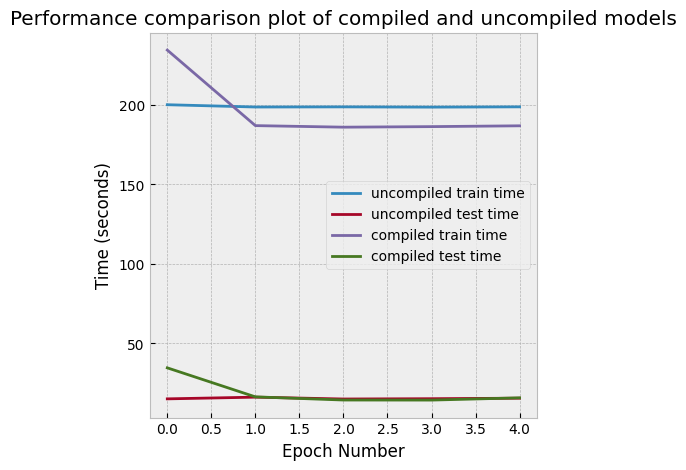

In [33]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize = (5,5))
plt.plot(r1.index, r1['train_epoch_time'], label = 'uncompiled train time')
plt.plot(r1.index, r1['test_epoch_time'], label = 'uncompiled test time')
plt.plot(r1.index, r2['train_epoch_time'], label = 'compiled train time')
plt.plot(r1.index, r2['test_epoch_time'], label = 'compiled test time')
plt.ylabel('Time (seconds)')
plt.xlabel('Epoch Number')
plt.title("Performance comparison plot of compiled and uncompiled models")
plt.legend()
plt.show()